In [23]:
from myneo4j import App
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
app = App(uri="bolt://localhost:7687", user="neo4j", pwd="frosch")

# configurations
### Louvain Algorithm
<html>
<body>
<!--StartFragment-->

|Name |Type | Default | Optional | Description|
-- | -- | --| -- | --
relationshipWeightProperty | String |  null | yes  | If set, the values stored at the given property are used as relationship weights during the computation. If not set, the graph is considered unweighted.
seedProperty | String | n/a | yes | Used to set the initial community for a node. The property value needs to be a number.
maxLevels | Integer | 10 | yes | The maximum number of levels in which the graph is clustered and then condensed.
maxIterations | Integer | 10 | yes | The maximum number of iterations that the modularity optimization will run for each level.
tolerance | Float | 0.0001 | yes | Minimum change in modularity between iterations. If the modularity changes less than the tolerance value, the result is considered stable and the algorithm returns.
includeIntermediateCommunities | Boolean | false | yes | Indicates whether to write intermediate communities. If set to false, only the final community is persisted.
consecutiveIds | Boolean | false | yes | Flag to decide whether component identifiers are mapped into a consecutive id space (requires additional memory). Cannot be used in combination with the includeIntermediateCommunities flag.

<!--EndFragment-->
</body>
</html>

In [7]:
louvainConfig = '''
    maxLevels: 10,
    maxIterations: 10,
    tolerance: 0.0001,
    includeIntermediateCommunities: False,
    consecutiveIds: False
'''

### Create a graph Projection topVenues with **Top200 + Articles** Labels and **VENUE + REFERENCEE** Relationship

In [4]:
### This Projection will create a graph with the top200 venues and all Articles and their relations VENUE + REFS
query_createTopConfisGraph = '''CALL gds.graph.create('venuesAndArticles', ['Top200','Article'], ['VENUE', 'REFERENCES'])'''
app.query(query=query_createTopConfisGraph)

[<Record nodeProjection={'Top200': {'properties': {}, 'label': 'Top200'}, 'Article': {'properties': {}, 'label': 'Article'}} relationshipProjection={'REFERENCES': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'REFERENCES', 'properties': {}}, 'VENUE': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'VENUE', 'properties': {}}} graphName='venuesAndArticles' nodeCount=424544 relationshipCount=1645108 createMillis=26830>]

### run Louvain Algorithm Stream **ESTIMATE**

In [ ]:
query = f'''CALL gds.louvain.stream.estimate('venuesAndArticles', {{{louvainConfig}}})'''
app.query(query=query)

### run Louvain Algorithm **STREAM**

In [13]:
query = f'''
CALL gds.louvain.stream('venuesAndArticles', {{{louvainConfig}}}) 
YIELD nodeId, communityId 
WITH gds.util.asNode(nodeId) AS n, communityId
WITH n, communityId,
CASE 
    WHEN "Article" in labels(n) THEN n.title
    WHEN "Top200" in labels(n) THEN n.name
END AS `title/name`
RETURN  labels(n) as Label, communityId as `Community ID`, `title/name` 
ORDER BY communityId LIMIT 10
'''
result = app.query(query=query)
dtf = pd.DataFrame([dict(_) for _ in result])
dtf.sample(10)

Query failed: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.louvain.stream`: Caused by: java.util.NoSuchElementException: Graph with name `venuesAndArticles` does not exist on database `dblpcopy`.}


TypeError: 'NoneType' object is not iterable

### run Louvain Algorithm **WRITE**

In [ ]:
query = f'''
CALL gds.louvain.write('venuesAndArticles', {{writeProperty: 'community_1', {louvainConfig}}}) 
YIELD modularity, modularities, communityCount, communityDistribution
'''
app.query(query=query)

### run Louvain Algorithm **STATS**

In [7]:
query = f'''
CALL gds.louvain.stats('venuesAndArticles', {{ {louvainConfig}}}) 
YIELD modularity, modularities, communityCount, communityDistribution

'''
app.query(query=query)

[<Record modularity=0.705839681950941 modularities=[0.5956209157797444, 0.705839681950941] communityCount=26 communityDistribution={'p99': 64233, 'min': 1293, 'max': 64233, 'mean': 16328.615384615385, 'p90': 21148, 'p50': 12618, 'p999': 64233, 'p95': 54547, 'p75': 17857}>]

### count distinct communities of a new Louvain Run

In [ ]:
query = f'''
CALL gds.louvain.stream('venuesAndArticles', {{{louvainConfig}}}) 
YIELD nodeId, communityId 
WITH DISTINCT communityId
RETURN Count(communityId) AS Communities
'''
app.query(query=query)

### get the stats for community_0 (Show the amount of either `Venues/Articles` per community) 
=> the biggest community is **Com. 15526**

Text(0.5, 0, 'Sum of community')

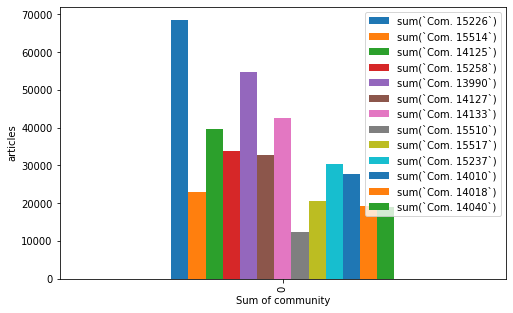

In [24]:
query = '''
// MATCH (n:Top200)
MATCH (n:Article)
// MATCH (n) WHERE n:Top200 OR n:Article
WITH
CASE n.community_0 WHEN 15226 THEN 1 ELSE 0 END AS `Com. 15226`,
CASE n.community_0 WHEN 15514 THEN 1 ELSE 0 END AS `Com. 15514`,
CASE n.community_0 WHEN 14125 THEN 1 ELSE 0 END AS `Com. 14125`,
CASE n.community_0 WHEN 15258 THEN 1 ELSE 0 END AS `Com. 15258`,
CASE n.community_0 WHEN 13990 THEN 1 ELSE 0 END AS `Com. 13990`,
CASE n.community_0 WHEN 14127 THEN 1 ELSE 0 END AS `Com. 14127`,
CASE n.community_0 WHEN 14133 THEN 1 ELSE 0 END AS `Com. 14133`,
CASE n.community_0 WHEN 15510 THEN 1 ELSE 0 END AS `Com. 15510`,
CASE n.community_0 WHEN 15517 THEN 1 ELSE 0 END AS `Com. 15517`,
CASE n.community_0 WHEN 15237 THEN 1 ELSE 0 END AS `Com. 15237`,
CASE n.community_0 WHEN 14010 THEN 1 ELSE 0 END AS `Com. 14010`,
CASE n.community_0 WHEN 14018 THEN 1 ELSE 0 END AS `Com. 14018`,
CASE n.community_0 WHEN 14040 THEN 1 ELSE 0 END AS `Com. 14040`
RETURN sum(`Com. 15226`), sum(`Com. 15514`), sum(`Com. 14125`),sum(`Com. 15258`),sum(`Com. 13990`),sum(`Com. 14127`),sum(`Com. 14133`), sum(`Com. 15510`), sum(`Com. 15517`),sum(`Com. 15237`),sum(`Com. 14010`),sum(`Com. 14018`),sum(`Com. 14040`)
'''
result = app.query(query=query)
dtf = pd.DataFrame([dict(_) for _ in result])
dtf.plot(kind="bar", figsize=(8,5))
plt.ylabel("articles")
plt.xlabel("community")

In [ ]:
app.close()